In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
kc_data_org = pd.read_csv("kc_house_data.csv")

In [4]:
kc_data_org['sale_yr'] = pd.to_numeric(kc_data_org.date.str.slice(0, 4))
kc_data_org['sale_month'] = pd.to_numeric(kc_data_org.date.str.slice(4, 6))
kc_data_org['sale_day'] = pd.to_numeric(kc_data_org.date.str.slice(6, 8))

kc_data = pd.DataFrame(kc_data_org, columns=[
        'sale_yr','sale_month','sale_day',
        'bedrooms','bathrooms','sqft_living','sqft_lot','floors',
        'condition','grade','sqft_above','sqft_basement','yr_built',
        'zipcode','lat','long','sqft_living15','sqft_lot15','price'])
label_col = 'price'

print(kc_data.describe())

            sale_yr    sale_month      sale_day      bedrooms     bathrooms  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean    2014.322954      6.574423     15.688197      3.370842      2.114757   
std        0.467616      3.115308      8.635063      0.930062      0.770163   
min     2014.000000      1.000000      1.000000      0.000000      0.000000   
25%     2014.000000      4.000000      8.000000      3.000000      1.750000   
50%     2014.000000      6.000000     16.000000      3.000000      2.250000   
75%     2015.000000      9.000000     23.000000      4.000000      2.500000   
max     2015.000000     12.000000     31.000000     33.000000      8.000000   

        sqft_living      sqft_lot        floors     condition         grade  \
count  21613.000000  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean    2079.899736  1.510697e+04      1.494309      3.409430      7.656873   
std      918.440897  4.142051e+04      0.539989    

In [5]:
def train_validate_test_split(df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

In [6]:
train_size, valid_size, test_size = (70, 30, 0)
kc_train, kc_valid, kc_test = train_validate_test_split(kc_data, 
                              train_part=train_size, 
                              validate_part=valid_size,
                              test_part=test_size,
                              seed=2017)

In [7]:
kc_y_train = kc_data.loc[kc_train, [label_col]]
kc_x_train = kc_data.loc[kc_train, :].drop(label_col, axis=1)
kc_y_valid = kc_data.loc[kc_valid, [label_col]]
kc_x_valid = kc_data.loc[kc_valid, :].drop(label_col, axis=1)

print('Size of training set: ', len(kc_x_train))
print('Size of validation set: ', len(kc_x_valid))
print('Size of test set: ', len(kc_test), '(not converted)')

Size of training set:  15129
Size of validation set:  6483
Size of test set:  1 (not converted)


In [8]:
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)


In [9]:
def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

In [10]:
stats = norm_stats(kc_x_train, kc_x_valid)
arr_x_train = np.array(z_score(kc_x_train, stats))
arr_y_train = np.array(kc_y_train)
arr_x_valid = np.array(z_score(kc_x_valid, stats))
arr_y_valid = np.array(kc_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

Training shape: (15129, 18)
Training samples:  15129
Validation samples:  6483


In [11]:
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [12]:
"""def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)"""

In [13]:
"""def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)"""

In [21]:
model = basic_model_1(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               1900      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 7,001
Trainable params: 7,001
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               1900      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
den

In [22]:
epochs = 500
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

Epochs:  500
Batch size:  128


In [23]:
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

In [24]:
history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, 
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Train on 15129 samples, validate on 6483 samples
Epoch 1/500
 - 0s - loss: 419717119839.7229 - mean_absolute_error: 536251.2219 - val_loss: 442199089532.3474 - val_mean_absolute_error: 549026.3573
Epoch 2/500
 - 0s - loss: 419577509143.0635 - mean_absolute_error: 536144.1734 - val_loss: 441956062422.9721 - val_mean_absolute_error: 548837.2326
Epoch 3/500
 - 0s - loss: 419261442333.2228 - mean_absolute_error: 535885.6888 - val_loss: 441538765359.7803 - val_mean_absolute_error: 548499.9501
Epoch 4/500
 - 0s - loss: 418778565142.8436 - mean_absolute_error: 535485.0483 - val_loss: 440951623175.1868 - val_mean_absolute_error: 548021.8147
Epoch 5/500
 - 0s - loss: 418134395216.6631 - mean_absolute_error: 534946.6044 - val_loss: 440206981393.8879 - val_mean_absolute_error: 547412.3550
Epoch 6/500
 - 0s - loss: 417335374359.2496 - mean_absolute_error: 534279.2501 - val_loss: 439300385064.0012 - val_mean_absolute_error: 546667.9322
Epoch 7/500
 - 0s - loss: 416381629042.2177 - mean_absolute_err

Epoch 56/500
 - 0s - loss: 262926310469.3767 - mean_absolute_error: 362765.4031 - val_loss: 279087076271.2867 - val_mean_absolute_error: 373057.6191
Epoch 57/500
 - 0s - loss: 259335119441.9999 - mean_absolute_error: 357953.1489 - val_loss: 275371733585.2661 - val_mean_absolute_error: 368247.3677
Epoch 58/500
 - 0s - loss: 255751267706.9659 - mean_absolute_error: 353151.3219 - val_loss: 271665890776.1172 - val_mean_absolute_error: 363417.5464
Epoch 59/500
 - 0s - loss: 252193643291.0231 - mean_absolute_error: 348306.8192 - val_loss: 267989586469.0396 - val_mean_absolute_error: 358592.6130
Epoch 60/500
 - 0s - loss: 248662572758.1878 - mean_absolute_error: 343488.6011 - val_loss: 264330903774.3958 - val_mean_absolute_error: 353757.6940
Epoch 61/500
 - 0s - loss: 245152947412.3265 - mean_absolute_error: 338669.2975 - val_loss: 260707771802.2002 - val_mean_absolute_error: 348951.1984
Epoch 62/500
 - 0s - loss: 241664143665.6635 - mean_absolute_error: 333844.9188 - val_loss: 257094884775.7

Epoch 111/500
 - 0s - loss: 116892252068.0843 - mean_absolute_error: 165748.8713 - val_loss: 126426481592.7639 - val_mean_absolute_error: 171377.1720
Epoch 112/500
 - 0s - loss: 115325333328.4262 - mean_absolute_error: 163965.0767 - val_loss: 124772342506.4791 - val_mean_absolute_error: 169483.7367
Epoch 113/500
 - 0s - loss: 113788284042.4150 - mean_absolute_error: 162180.7376 - val_loss: 123148131510.4340 - val_mean_absolute_error: 167609.3898
Epoch 114/500
 - 0s - loss: 112275493900.6570 - mean_absolute_error: 160457.3894 - val_loss: 121553962480.1259 - val_mean_absolute_error: 165806.3518
Epoch 115/500
 - 0s - loss: 110779465883.9453 - mean_absolute_error: 158738.1733 - val_loss: 119978101187.4256 - val_mean_absolute_error: 164037.0566
Epoch 116/500
 - 0s - loss: 109318317173.9742 - mean_absolute_error: 157047.5394 - val_loss: 118419440395.6489 - val_mean_absolute_error: 162260.8628
Epoch 117/500
 - 0s - loss: 107878031067.3319 - mean_absolute_error: 155416.8270 - val_loss: 1169014

Epoch 167/500
 - 0s - loss: 60519531849.1501 - mean_absolute_error: 107575.2001 - val_loss: 67424006435.2627 - val_mean_absolute_error: 108739.9892
Epoch 168/500
 - 0s - loss: 59900158805.9087 - mean_absolute_error: 106951.3963 - val_loss: 66798759541.1211 - val_mean_absolute_error: 108323.3609
Epoch 169/500
 - 0s - loss: 59295180522.0871 - mean_absolute_error: 106528.6282 - val_loss: 66210429722.4964 - val_mean_absolute_error: 107827.0924
Epoch 170/500
 - 0s - loss: 58705800304.6948 - mean_absolute_error: 106006.3646 - val_loss: 65613565634.2014 - val_mean_absolute_error: 107398.2632
Epoch 171/500
 - 0s - loss: 58127091332.3572 - mean_absolute_error: 105537.8985 - val_loss: 65047633050.6346 - val_mean_absolute_error: 106970.2937
Epoch 172/500
 - 0s - loss: 57561949190.3962 - mean_absolute_error: 105046.5653 - val_loss: 64494773075.6748 - val_mean_absolute_error: 106548.4061
Epoch 173/500
 - 0s - loss: 57009407434.0215 - mean_absolute_error: 104568.1632 - val_loss: 63943323107.8056 - v

Epoch 223/500
 - 0s - loss: 37189604068.6047 - mean_absolute_error: 86842.5777 - val_loss: 44713905166.3736 - val_mean_absolute_error: 90509.0764
Epoch 224/500
 - 0s - loss: 36954636198.3856 - mean_absolute_error: 86500.5016 - val_loss: 44484401916.8015 - val_mean_absolute_error: 90426.9627
Epoch 225/500
 - 0s - loss: 36711103151.4046 - mean_absolute_error: 86504.0166 - val_loss: 44253105074.1299 - val_mean_absolute_error: 90095.0794
Epoch 226/500
 - 0s - loss: 36485579929.2379 - mean_absolute_error: 86087.8543 - val_loss: 44034725688.0333 - val_mean_absolute_error: 90125.2414
Epoch 227/500
 - 0s - loss: 36258917260.9701 - mean_absolute_error: 85921.7001 - val_loss: 43827038459.7748 - val_mean_absolute_error: 90039.5633
Epoch 228/500
 - 0s - loss: 36033888988.3471 - mean_absolute_error: 85916.2361 - val_loss: 43602074002.7765 - val_mean_absolute_error: 89693.5842
Epoch 229/500
 - 0s - loss: 35812855065.5002 - mean_absolute_error: 85633.2685 - val_loss: 43396436978.2582 - val_mean_absol

Epoch 280/500
 - 0s - loss: 27935530266.5493 - mean_absolute_error: 79257.0769 - val_loss: 36044714980.3585 - val_mean_absolute_error: 85130.3950
Epoch 281/500
 - 0s - loss: 27831894329.3965 - mean_absolute_error: 79168.8095 - val_loss: 35917407177.8226 - val_mean_absolute_error: 84868.5909
Epoch 282/500
 - 0s - loss: 27734136204.5640 - mean_absolute_error: 79082.8677 - val_loss: 35857595340.6657 - val_mean_absolute_error: 85039.3582
Epoch 283/500
 - 0s - loss: 27631369150.4813 - mean_absolute_error: 79089.8094 - val_loss: 35745139540.6226 - val_mean_absolute_error: 84863.8740
Epoch 284/500
 - 0s - loss: 27535768709.9478 - mean_absolute_error: 78896.6367 - val_loss: 35687095548.5646 - val_mean_absolute_error: 85046.4229
Epoch 285/500
 - 0s - loss: 27449262615.1143 - mean_absolute_error: 78865.6288 - val_loss: 35562783042.2212 - val_mean_absolute_error: 84759.5984
Epoch 286/500
 - 0s - loss: 27349338368.2538 - mean_absolute_error: 78780.6927 - val_loss: 35485929072.0666 - val_mean_absol

Epoch 337/500
 - 0s - loss: 23755060010.8613 - mean_absolute_error: 75934.3099 - val_loss: 32057852152.9317 - val_mean_absolute_error: 83034.8550
Epoch 338/500
 - 0s - loss: 23702009989.7447 - mean_absolute_error: 75844.3504 - val_loss: 31998085798.2440 - val_mean_absolute_error: 83057.4748
Epoch 339/500
 - 0s - loss: 23656684787.2584 - mean_absolute_error: 75988.4141 - val_loss: 31951512327.8581 - val_mean_absolute_error: 82956.1990
Epoch 340/500
 - 0s - loss: 23606003205.7193 - mean_absolute_error: 75784.8244 - val_loss: 31921449136.9058 - val_mean_absolute_error: 83072.7621
Epoch 341/500
 - 0s - loss: 23550909624.1021 - mean_absolute_error: 75844.7761 - val_loss: 31858317184.6910 - val_mean_absolute_error: 82946.0414
Epoch 342/500
 - 0s - loss: 23497795567.4850 - mean_absolute_error: 75878.4474 - val_loss: 31806416574.4106 - val_mean_absolute_error: 82851.9887
Epoch 343/500
 - 0s - loss: 23456850705.1411 - mean_absolute_error: 75769.1476 - val_loss: 31773181457.2957 - val_mean_absol

Epoch 394/500
 - 0s - loss: 21373632147.2140 - mean_absolute_error: 74345.7193 - val_loss: 30053133434.0966 - val_mean_absolute_error: 82271.4493
Epoch 395/500
 - 0s - loss: 21338074556.4846 - mean_absolute_error: 74208.4999 - val_loss: 30051247523.9932 - val_mean_absolute_error: 82512.6774
Epoch 396/500
 - 0s - loss: 21311180767.9175 - mean_absolute_error: 74420.9837 - val_loss: 29982009515.5354 - val_mean_absolute_error: 82136.4185
Epoch 397/500
 - 0s - loss: 21264540219.4440 - mean_absolute_error: 74202.1940 - val_loss: 29954995912.2036 - val_mean_absolute_error: 82184.0029
Epoch 398/500
 - 0s - loss: 21233911955.4170 - mean_absolute_error: 74179.6113 - val_loss: 29946310357.7874 - val_mean_absolute_error: 82438.2429
Epoch 399/500
 - 0s - loss: 21197780988.8865 - mean_absolute_error: 74077.2791 - val_loss: 29964285487.3065 - val_mean_absolute_error: 82616.9887
Epoch 400/500
 - 0s - loss: 21174910753.3177 - mean_absolute_error: 74192.0734 - val_loss: 29910449778.9098 - val_mean_absol

In [25]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  73282.5081 , Train Loss:  19761079471.3707
Val MAE:  82492.8787 , Val Loss:  29129984705.0958


In [26]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

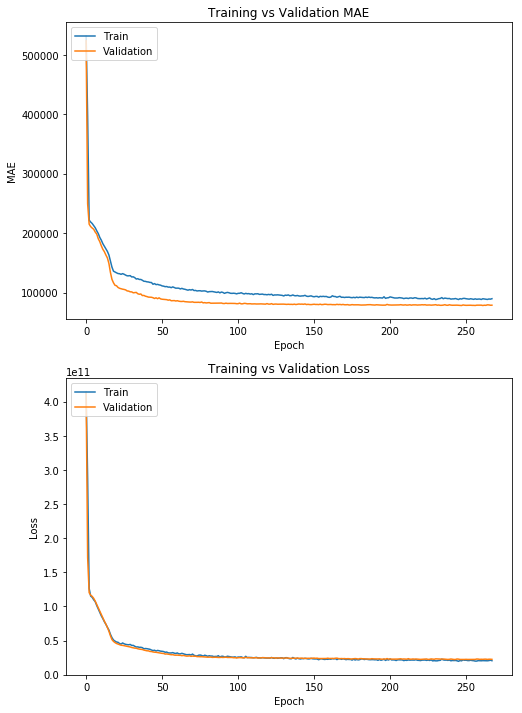

In [20]:
plot_hist(history.history, xsize=8, ysize=12)